In [1]:
rm(list=ls())
library('Biobase')
library('limma')
library("biomaRt")
library("edgeR")
# library("Glimma")
library("repr")

options(repr.plot.width=10, repr.plot.height=10)

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.



Attaching package: ‘limma’


The following object is masked from ‘package:BiocGenerics’:

    plotMA




In [2]:
PATH = paste(getwd())
PATH_DATA = paste(PATH, 'Data', sep = .Platform$file.sep)


#### Load annotations

In [3]:
## Remove duplicates in ensembl_gene_id column
annot <- read.csv(file = paste(PATH_DATA, 'Annotations.tsv', sep = .Platform$file.sep), sep = '\t', header = TRUE)
annot <- annot[!duplicated(annot$ensembl_gene_id), ]
rownames(annot) <- annot$ensembl_gene_id

head(annot)
dim(annot)

,ensembl_gene_id,entrezgene_id,hgnc_symbol,chromosome_name,strand,start_position,end_position,gene_biotype
,<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>,<chr>
ENSG00000210049,ENSG00000210049,NA,MT-TF,MT,1,577,647,Mt_tRNA
ENSG00000211459,ENSG00000211459,NA,MT-RNR1,MT,1,648,1601,Mt_rRNA
ENSG00000210077,ENSG00000210077,NA,MT-TV,MT,1,1602,1670,Mt_tRNA
ENSG00000210082,ENSG00000210082,NA,MT-RNR2,MT,1,1671,3229,Mt_rRNA
ENSG00000209082,ENSG00000209082,NA,MT-TL1,MT,1,3230,3304,Mt_tRNA
ENSG00000198888,ENSG00000198888,4535,MT-ND1,MT,1,3307,4262,protein_coding


[1] 68016     8

In [4]:
## Load expression data
counts <- read.delim(paste(PATH_DATA, 'gene_counts.tsv', sep = .Platform$file.sep), row.names = 1)
colnames(counts) <- gsub("X","",colnames(counts))
tail(counts)
dim(counts)


,110188,111485,111733,112434,113223,113321,113402,114430,114469,114718,⋯,394540,394765,394806,394913,395879,396641,398087,399652,399773,399891
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000282817,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000282818,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000282819,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000282820,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000282821,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000282822,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 65988   443

#### Load metadata

In [5]:
meta <- read.delim( paste(PATH_DATA, 'metadata.tsv', sep = .Platform$file.sep), row.names=1)
head(meta)
dim(meta)

,basevitdng,wk32to38vitdng,mayocbloodvitd,condition,deliverydate,site,bdeath,trmt,cgender,cethnicity,crace,craceeth
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
110188,33.10,13.3,7.9,NA,03/09/2011,1,No,B,Female,Not_Hispanic_or_Latino,Asian,Other
111485,22.10,44.6,22.0,NA,01/17/2011,1,No,A,Male,Not_Hispanic_or_Latino,Black__African_American,AfricanAmericanHispanicandNonHispanic
111733,16.40,30.3,18.0,NA,09/22/2010,1,No,B,Male,Not_Hispanic_or_Latino,Asian,Other
112434,7.94,54.5,25.0,NA,09/30/2010,1,No,A,Female,Hispanic_or_Latino,Asian,Other
113223,40.30,45.9,47.0,1,09/29/2010,1,No,B,Female,Not_Hispanic_or_Latino,White,CaucasianNonHispanic
113321,18.70,27.7,24.0,NA,11/21/2010,1,No,B,Male,Hispanic_or_Latino,White,CaucasianHispanic


[1] 443  12

In [6]:
counts <- counts[,rownames(meta)]


In [7]:
dim(counts)
dim(meta)


[1] 65988   443

[1] 443  12

In [8]:
samples <- colnames(counts)
nsamples <- length(samples)

### Normalize

In [9]:
x <- DGEList(counts)
dim(x)

[1] 65988   443

In [10]:
## Store meta information in x
x$genes <- annot
samplenames <- rownames(meta)

group <- meta$condition
x$samples$group <- meta$condition

In [11]:
## Convert counts to cpm and log-cpm

cpm <- cpm(x)
lcpm <- cpm(x, log=TRUE)

L <- mean(x$samples$lib.size) * 1e-6
M <- median(x$samples$lib.size) * 1e-6
c(L, M)


[1] 4.489794 4.276713

In [12]:
## Removing genes with lowly expressed genes
table(rowSums(x$counts==0)==nsamples)


FALSE  TRUE 
56999  8989 

In [13]:
## Larger the library size, lower the CPM cutoff and vice versa
keep.exprs <- filterByExpr(x, group=group, min.count = 12)
x <- x[keep.exprs,, keep.lib.sizes=FALSE]
dim(x)

write.csv(x$counts, paste(PATH_DATA, 'filtered_gene_counts.csv', sep = .Platform$file.sep) )

[1] 13214   443

Warning message in brewer.pal(nsamples, "Paired"):
“n too large, allowed maximum for palette Paired is 12
Returning the palette you asked for with that many colors
”


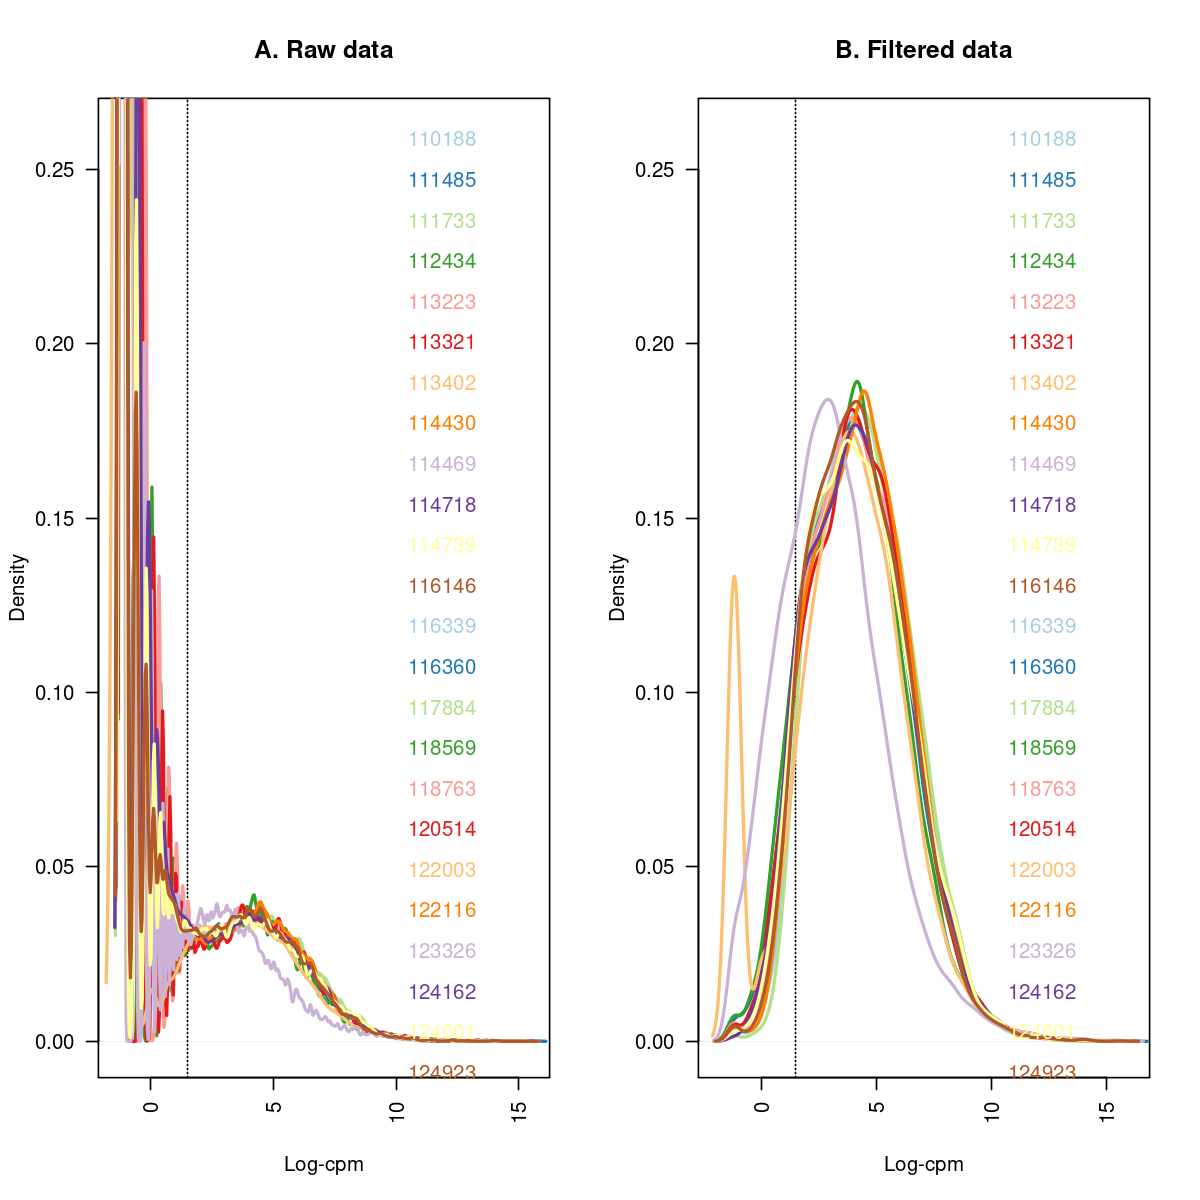

In [14]:
lcpm.cutoff <- log2(10/M + 2/L)
library(RColorBrewer)
nsamples <- ncol(x)
col <- brewer.pal(nsamples, "Paired")
par(mfrow=c(1,2))
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.26), las=2, main="", xlab="")
title(main="A. Raw data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)

for (i in 2:nsamples){
 den <- density(lcpm[,i])
 lines(den$x, den$y, col=col[i], lwd=2)
}


legend("topright", samples, text.col=col, bty="n")
lcpm <- cpm(x, log=TRUE)
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.26), las=2, main="", xlab="")
title(main="B. Filtered data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)

for (i in 2:nsamples){
 den <- density(lcpm[,i])
 lines(den$x, den$y, col=col[i], lwd=2)
}

legend("topright", samples, text.col=col, bty="n")

In [15]:
x <- calcNormFactors(x, method = "TMM")
#x$samples$norm.factors

In [16]:
x2 <- x
x2$samples$norm.factors <- 1
x2$counts[,1] <- ceiling(x2$counts[,1]*0.05)
x2$counts[,2] <- x2$counts[,2]*5

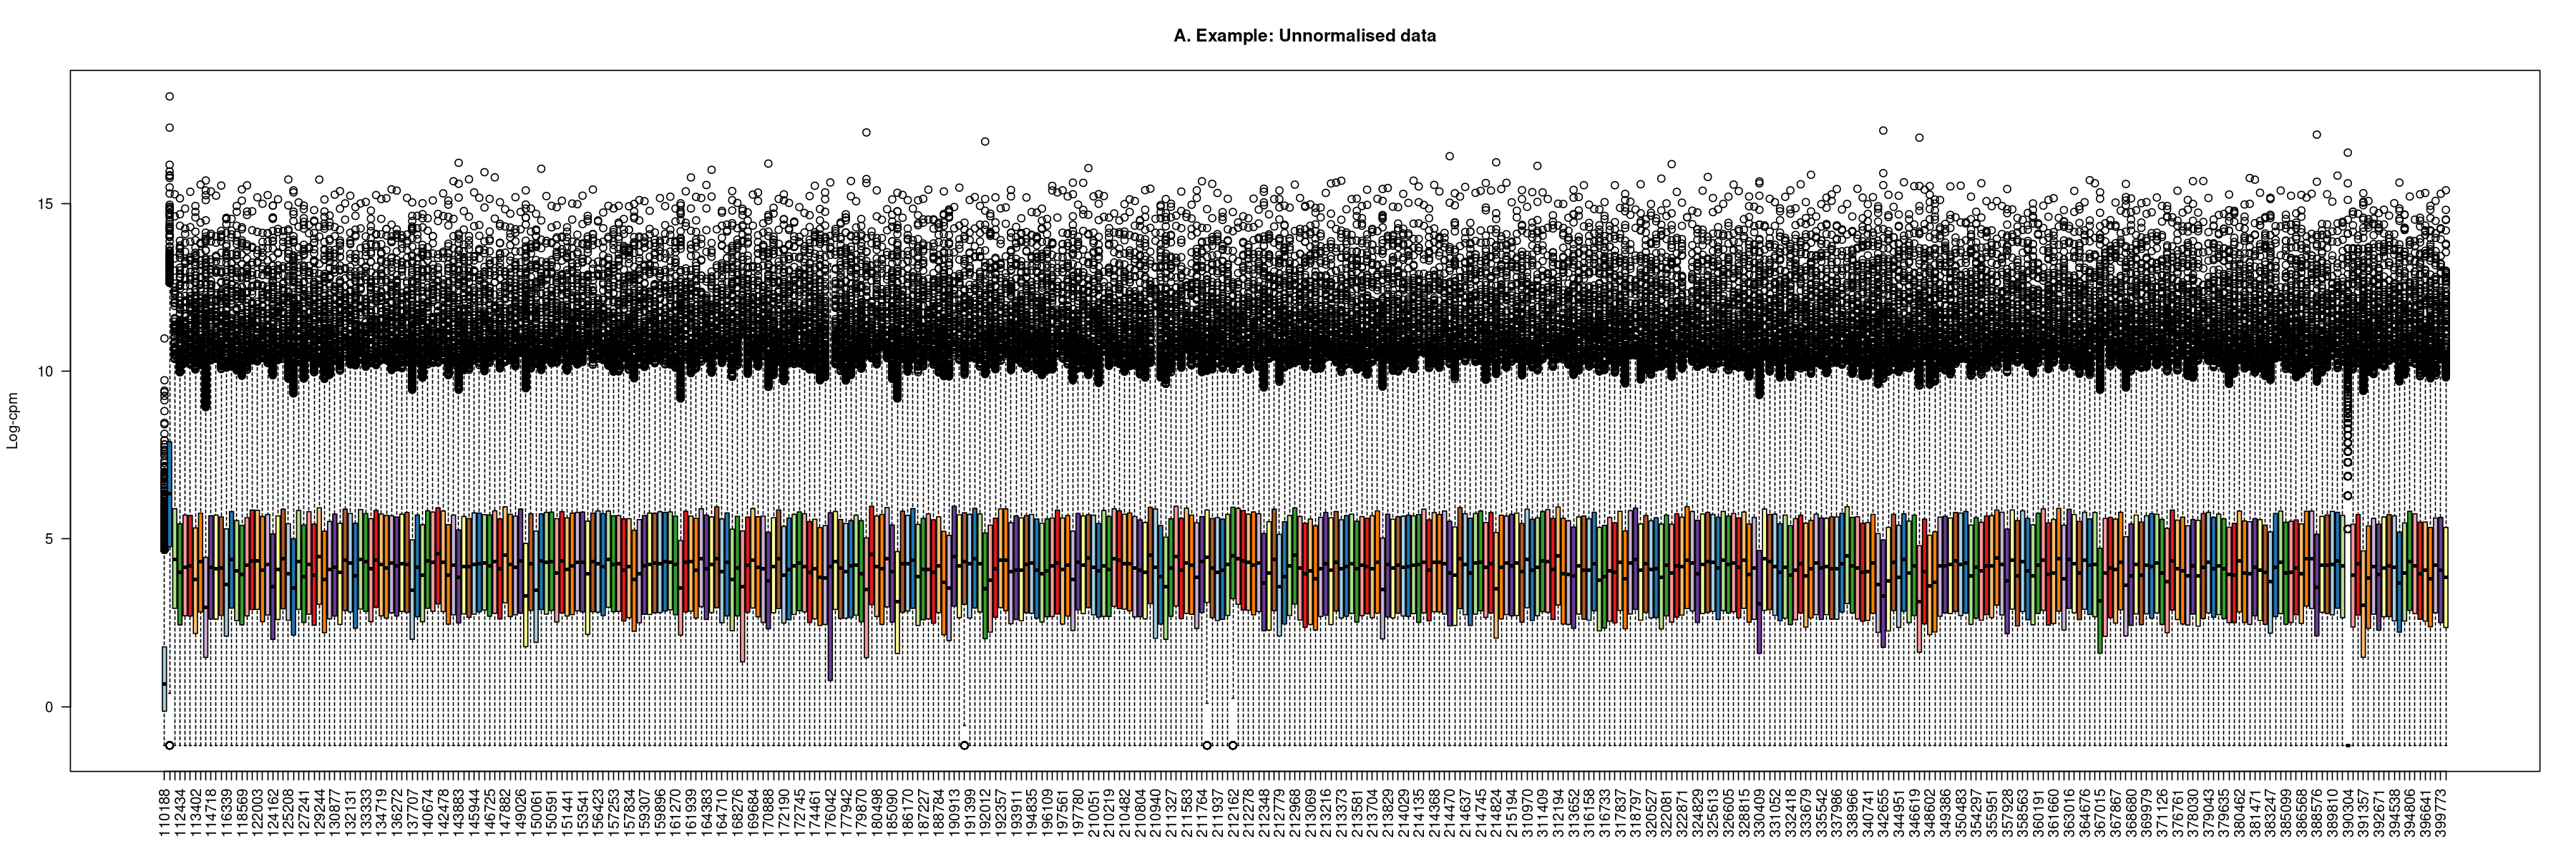

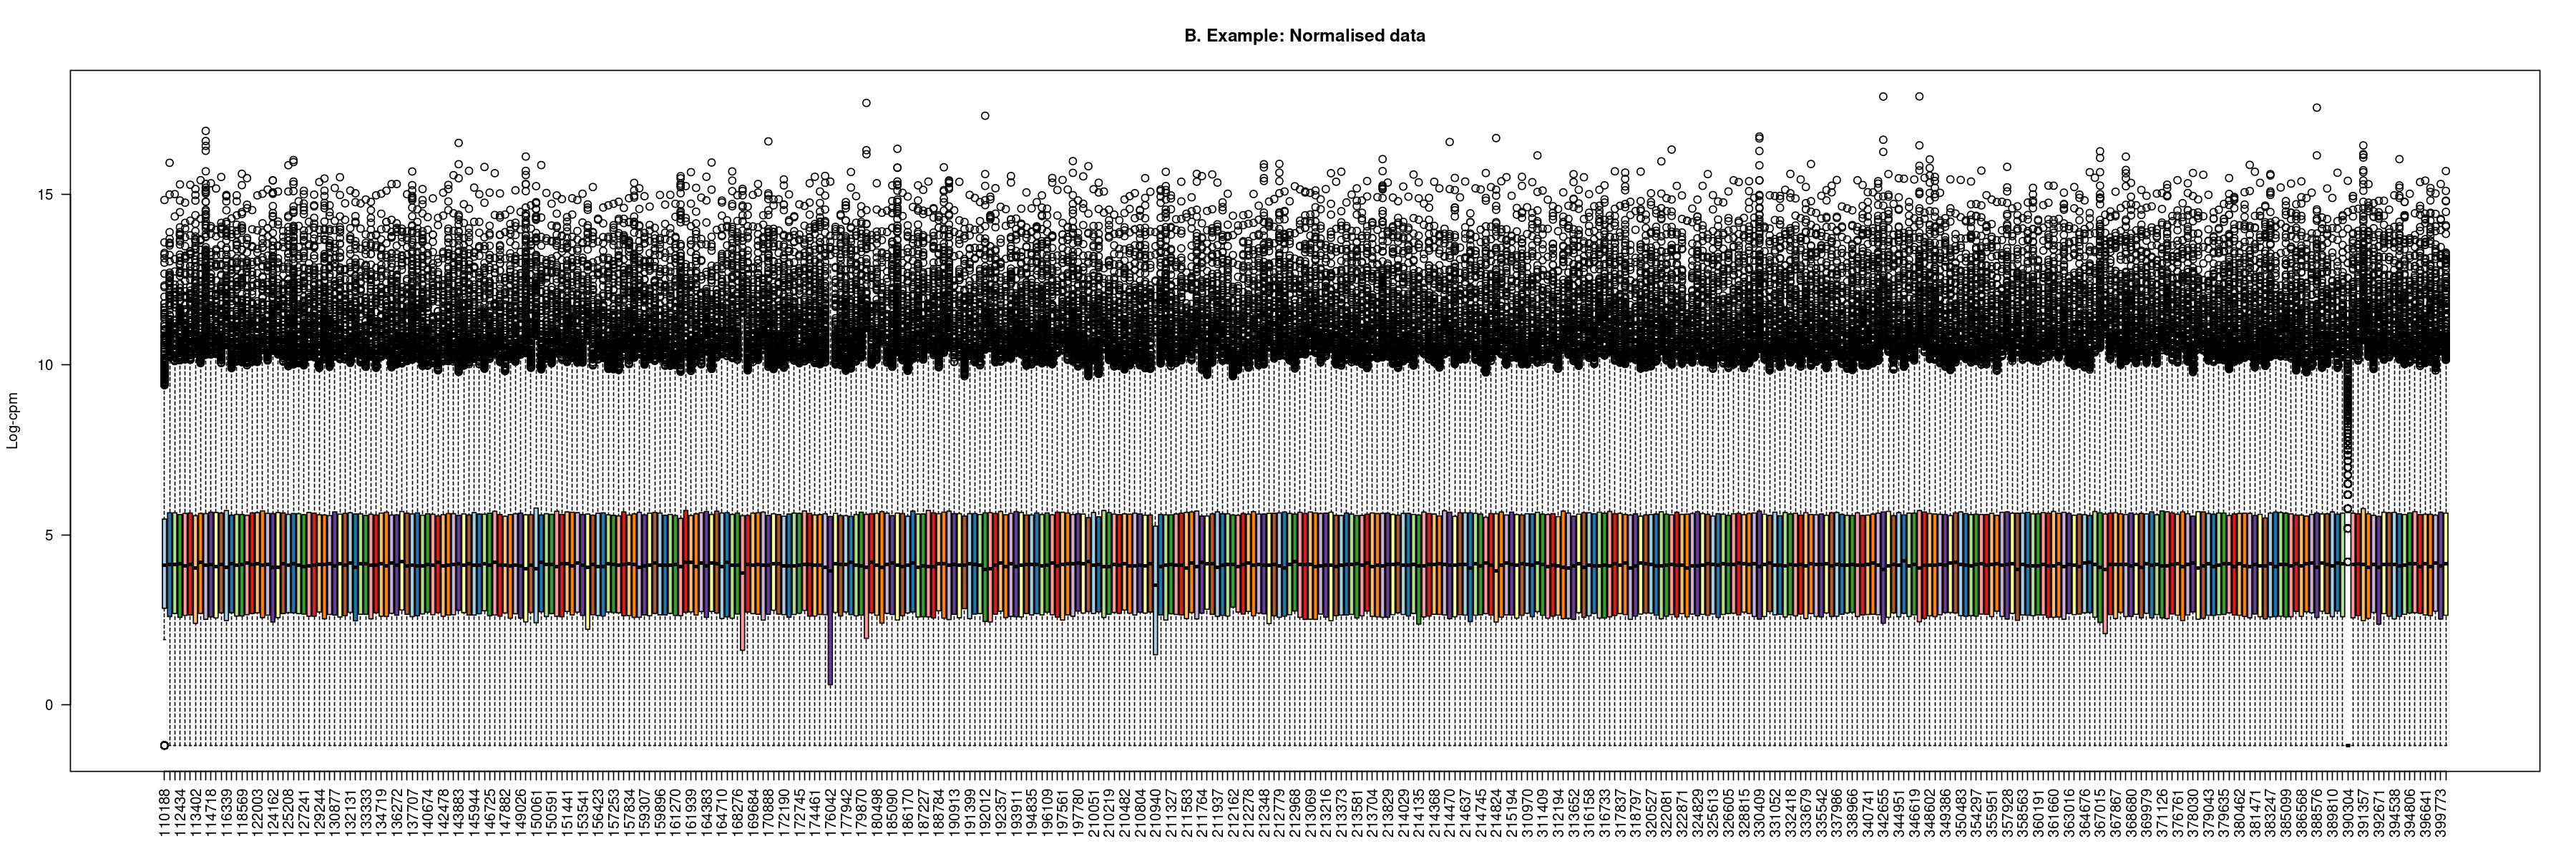

In [17]:
options(repr.plot.width=30, repr.plot.height=10)
lcpm <- cpm(x2, log=TRUE)
boxplot(lcpm, las=2, col=col, main="")
title(main="A. Example: Unnormalised data", ylab="Log-cpm")
x2 <- calcNormFactors(x2)
#x2$samples$norm.factors
lcpm <- cpm(x2, log=TRUE)
boxplot(lcpm, las=2, col=col, main="")
title(main="B. Example: Normalised data", ylab="Log-cpm")

In [18]:
write.csv(lcpm, paste(PATH_DATA, 'normalized_gene_counts.csv', sep = .Platform$file.sep) )

In [19]:
dim(lcpm)

[1] 13214   443